# Roadmap -- Distortion

This is the real dataset test of [Experiment Distortion](https://github.com/ZhiruiFeng/explorer/blob/master/test/RandomGraph.ipynb).

Here we have our dataset from [DIMACS](http://www.diag.uniroma1.it/challenge9/).

Then we will analysis the distortion on this graph as what we have done on random graph.

In [85]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import heuristic.fastmap.utils as utils
from heuristic.fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff, difastmap_max 
import heuristic.fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
import numpy as np
import math
from random import sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load the graph**

In [86]:
filepath = "../data/roadmap/rome99.road"

def readDiGraph_type(infile):
    G = nx.DiGraph()
    with open(infile) as f:
        l = f.readline()
        while l:
            if l[0] != 'a':
                l = f.readline()
                continue
            items = l.strip().split()
            if len(items) == 4:
                node1, node2, weight = items[1:]
            elif len(items) == 3:
                node1, node2 = items[1:]
                wight = 1.0
            G.add_edge(node1, node2, weight=float(weight))
            l = f.readline()
    return G

In [87]:
G = readDiGraph_type(filepath)

In [88]:
utils.connectivity_info(G)
countn = G.number_of_nodes()
counte = G.number_of_edges()
density = float(counte)/(countn * (countn-1))
print(countn)
print(counte)
print(density)

A strongly connected graph.
3353
8859
0.0007882194337418775


In [89]:
def get_dijkstra_path_length(G):
    dijkstra_path_length = {}
    for node in G.nodes:
        dijkstra_path_length[node] = nx.single_source_dijkstra_path_length(G, node)
    return dijkstra_path_length

In [90]:
dijkstra_path_length = get_dijkstra_path_length(G)

In [91]:
def thedistance_info(G):
    dis = []
    nodelist = list(G.nodes())
    for i in range(G.number_of_nodes()):
        length = dijkstra_path_length[nodelist[i]]
        dis.extend(list(length.values()))
    plt.hist(dis)
    plt.xlabel('distance')
    plt.ylabel('count (persents)')
    plt.title('Statistic of pair distances')
    plt.show()

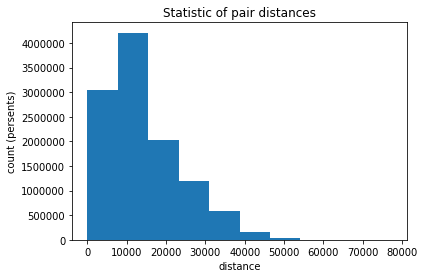

In [92]:
thedistance_info(G)

## Distortion of embedding average and max

In [93]:
def meta_distortion_analyse(i):
    global G, embedding, subset, alg, variant, threshold
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        if variant == 'undirected':
            target_dis = distance
        elif variant == 'average':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = (float(distance) + float(distance_reverse))/2
        elif variant == 'max':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = max(float(distance), float(distance_reverse))
        elif variant == 'diff':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = abs(float(distance) - float(distance_reverse))/2
        if alg == 'L1':
            embdis = np.sum(np.abs(emb_1-emb_2))
        elif alg == 'L2':
            embdis = math.sqrt(np.dot(emb_1-emb_2, emb_1-emb_2))
        if embdis > target_dis + threshold:
            larger += 1
        elif embdis < target_dis - threshold:
            smaller += 1
        else:
            equal += 1
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d, larger, equal, smaller]

def distortion_analyse_mp(G, embedding, subset, alg, variant, threshold):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_analyse, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d, larger, equal, smaller = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base

    return float(sigma)/ave_d, larger, equal, smaller

In [94]:
klist = [2, 3, 4, 5, 6, 7]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 20
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:2
Pool size: 8
(0.1501690891837608, 538114.0, 37112.0, 3422774.0)
#########Test for K:3
Pool size: 8
(0.09864116289347953, 1331642.0, 58396.0, 2607962.0)
#########Test for K:4
Pool size: 8
(0.10808589677097144, 1718508.0, 56580.0, 2222912.0)
#########Test for K:5
Pool size: 8
(0.10272467014041221, 2366164.0, 64950.0, 1566886.0)
#########Test for K:6
Pool size: 8
(0.11487044168304744, 2689708.0, 61998.0, 1246294.0)
#########Test for K:7
Pool size: 8
(0.11175756008899183, 3031032.0, 52552.0, 914416.0)


In [95]:
klist = [1, 2, 3, 4, 5]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 20
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:1
Pool size: 8
(0.710744726707453, 0.0, 7696.0, 3990304.0)
#########Test for K:2
Pool size: 8
(0.20573555632452817, 2152656.0, 38860.0, 1806484.0)
#########Test for K:3
Pool size: 8
(0.3111985902444959, 3321540.0, 20252.0, 656208.0)
#########Test for K:4
Pool size: 8
(0.3701012142194539, 3610378.0, 13134.0, 374488.0)
#########Test for K:5
Pool size: 8
(0.44492299392147283, 3794694.0, 8996.0, 194310.0)


In [96]:
klist = [2, 3, 4, 5, 6, 7, 8]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 20
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:2
Pool size: 8
(0.14768512527820965, 518864.0, 34244.0, 3444892.0)
#########Test for K:3
Pool size: 8
(0.10069886001035086, 1230532.0, 52938.0, 2714530.0)
#########Test for K:4
Pool size: 8
(0.1046932872752638, 1683120.0, 52900.0, 2261980.0)
#########Test for K:5
Pool size: 8
(0.09396217683777658, 2150168.0, 68458.0, 1779374.0)
#########Test for K:6
Pool size: 8
(0.09681681090633258, 2455128.0, 71550.0, 1471322.0)
#########Test for K:7
Pool size: 8
(0.12560319145753998, 2889298.0, 66284.0, 1042418.0)
#########Test for K:8
Pool size: 8
(0.1187890663387309, 3239424.0, 54606.0, 703970.0)


In [97]:
klist = [1, 2, 3, 4, 5, 6, 7, 8]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 20
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:1
Pool size: 8
(0.7102999153585338, 0.0, 8132.0, 3989868.0)
#########Test for K:2
Pool size: 8
(0.19810884130123493, 2154638.0, 38446.0, 1804916.0)
#########Test for K:3
Pool size: 8
(0.3092737050908313, 3311036.0, 20306.0, 666658.0)
#########Test for K:4
Pool size: 8
(0.3762249320083465, 3595236.0, 13656.0, 389108.0)
#########Test for K:5
Pool size: 8
(0.44039579536804646, 3796512.0, 9044.0, 192444.0)
#########Test for K:6
Pool size: 8
(0.5817349549278109, 3881152.0, 5568.0, 111280.0)
#########Test for K:7
Pool size: 8
(0.5691934677764731, 3946782.0, 3140.0, 48078.0)
#########Test for K:8
Pool size: 8
(0.7066407407606299, 3955996.0, 2606.0, 39398.0)


**Conclusion**

Except that $K$ here is very small in roadmap compared with $K$ in the random graph. And $L_2$ performs way better than $L_1$.

**Attention:** Figure out the theoretical reason behind is very important in this period.

## Test the distortion of embedding min

In [98]:
def meta_distortion_min(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        distance_reverse = dijkstra_path_length[node_2][node_1]
        target_dis = min(float(distance), float(distance_reverse))
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        embdis = 2.0*embdis_aver - embdis_max
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_min_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_min, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [100]:
klist = [2, 3, 4, 5, 6]
for K1 in klist:
    for K2 in klist:
        print("#########Test for K1:{}, K2:{}".format(K1, K2))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K1, epsilon, dis_store, alg)
        embedding_max = difastmap_max(G, K2, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
        print(results)

#########Test for K1:2, K2:2
Pool size: 8
0.14491048055989042
#########Test for K1:2, K2:3
Pool size: 8
0.2556035717671641
#########Test for K1:2, K2:4
Pool size: 8
0.27627993027023534
#########Test for K1:2, K2:5
Pool size: 8
0.3041854118851774
#########Test for K1:2, K2:6
Pool size: 8
0.2970098125010851
#########Test for K1:3, K2:2
Pool size: 8
0.1623076993603434
#########Test for K1:3, K2:3
Pool size: 8
0.10045194558113624
#########Test for K1:3, K2:4
Pool size: 8
0.12825086593006915
#########Test for K1:3, K2:5
Pool size: 8
0.15801055590264104
#########Test for K1:3, K2:6
Pool size: 8
0.16537220362754482
#########Test for K1:4, K2:2
Pool size: 8
0.20468186571985636
#########Test for K1:4, K2:3
Pool size: 8
0.1487865278007752
#########Test for K1:4, K2:4
Pool size: 8
0.11113317289694581
#########Test for K1:4, K2:5
Pool size: 8
0.13892324602589587
#########Test for K1:4, K2:6
Pool size: 8
0.1463845768496332
#########Test for K1:5, K2:2
Pool size: 8
0.25170936246143505
#########Test 

**Conclusion**

The approximation of the `min`, which didn't get directly, is also fairly promissing. 

The the whole precision line on the accuracy of predicting the comparison reasult of $d_{ij}$ and $d_{ji}$.

## Test the distortion of differential heuristic

In [101]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def meta_distortion_dh(i):
    global G, dis_store, subset, pick
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        target_dis = distance
        lower, upper = edgebound(dis_store['pivots'], dis_store[node_1], dis_store[node_2])
        if pick == 'upper':
            embdis = upper
        elif pick == 'lower':
            embdis = lower
        elif pick == 'median':
            embdis = (float(upper)+float(lower))/2
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_dh_mp(G, dis_store, subset, pick='upper'):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [102]:
klist = [3, 4, 5, 6, 7, 8, 9, 10]
for K in klist:
    print("!!!!!!!!!The number of K: {}".format(K))
    picklist = ['upper', 'lower', 'median']
    for pick in picklist:
        print("#########Test for differential heuristic:{}".format(pick))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding = difastmap_max(G, K, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_dh_mp(G, dis_store, subset, pick)
        print(results)

!!!!!!!!!The number of K: 3
#########Test for differential heuristic:upper
Pool size: 8
2.742439115719525
#########Test for differential heuristic:lower
Pool size: 8
0.1122370855300115
#########Test for differential heuristic:median
Pool size: 8
1.3422907985687438
!!!!!!!!!The number of K: 4
#########Test for differential heuristic:upper
Pool size: 8
2.31403990773282
#########Test for differential heuristic:lower
Pool size: 8
0.10005880779224606
#########Test for differential heuristic:median
Pool size: 8
1.1653398640708543
!!!!!!!!!The number of K: 5
#########Test for differential heuristic:upper
Pool size: 8
2.3382377154872316
#########Test for differential heuristic:lower
Pool size: 8
0.0856530531035157
#########Test for differential heuristic:median
Pool size: 8
1.1672490740137924
!!!!!!!!!The number of K: 6
#########Test for differential heuristic:upper
Pool size: 8
2.277559910460499
#########Test for differential heuristic:lower
Pool size: 8
0.07426925865326374
#########Test for 

**Conclusion**

While using the differential heuristic, the lower bound is amazingly good, and it even keeps the property of admissibility.

**Next planning**

1. I have a theory: the distrotion here has a very tight relation with the scale of the weight of the edge, so we can adjust it to see the change of performance. (make the weight of the edges closer, to see whether it's the sturcture of the graph of just the weight that plays an important role.)
    - This assumption of difference between weights is right proved by latter experiments.
    - **Structures** still havn't been proved, which is more interesting in this topic.
2. Try to analyse the combination, and the details in different situations.
3. **Try to analyse the reason why differential heuristic can performs so good, because it's kind of counterintuitive.**
    - It has something to do with the edges' weight, because when the edge is very different, the lower bound can be very accurate.

## Fine-tune the approximation of distances.

In [103]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def compare(pivots, pivots_dis_i, pivots_dis_j, disaver, dismax, realdis):
    lower, upper = edgebound(pivots, pivots_dis_i, pivots_dis_j)
    median = (float(lower)+float(upper))/2
    dismin = 2.0*disaver - dismax
    if dismin < 0:
        dismin = 0
    if upper <= dismin:
        state = 1
        distune = upper
        substate = 1 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismin and upper <= disaver and lower <=dismin:
        state = 2
        distune = dismin
        substate = 4 + np.argmin(np.abs(np.array([lower, dismin, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <=dismin: # spe
        state = 3
        distune = median
        substate = 8 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, upper])-realdis))
    elif upper > dismax and lower <=dismin: # spe
        state = 4
        distune = disaver
        substate = 13 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, dismax, upper])-realdis))
    elif upper <= disaver and lower > dismin:
        state = 5
        distune = lower
        substate = 19 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <= disaver and lower > dismin:
        state = 6
        distune = disaver
        substate = 22 + np.argmin(np.abs(np.array([lower, median, disaver, upper])-realdis))
    elif upper > dismax and lower <= disaver and lower > dismin: #spe
        state = 7
        distune = dismax
        substate = 26 + np.argmin(np.abs(np.array([lower, disaver, median, dismax, upper])-realdis))
    elif upper <= dismax and lower > disaver:
        state = 8
        distune = upper
        substate = 31 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismax and lower <= dismax:
        state = 9
        distune = dismax
        substate = 34 + np.argmin(np.abs(np.array([lower, median, dismax, upper])-realdis))
    elif lower > dismax:
        state = 10
        distune = lower
        substate = 38 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    else:
        state = 0
        distune = disaver
    return state, distune, substate

def meta_fastmap_dh(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    compare_state = []
    for t in range(11):
        compare_state.append(0)
    compare_substate = []
    for t in range(41):
        compare_substate.append(0)
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        target_dis = distance
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        state, tunedis, substate = compare(dis_store['pivots'], dis_store[node_1], dis_store[node_2], embdis_aver, embdis_max, target_dis)
        compare_state[state] += 1
        compare_substate[substate] += 1 
        sigma += (target_dis-tunedis)*(target_dis-tunedis)
        ave_d += target_dis
    output = list([sigma, ave_d])
    for n in compare_state:
        output.append(n)
    for n in compare_substate:
        output.append(n)
    return output

def draw_distribution(states, xl, yl, title):
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.show()
    
def fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_fastmap_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    resultsum = np.sum(pool_outputs, 0)
    sigma, ave_d = resultsum[:2]
    states = resultsum[2:13]
    substates = resultsum[13:]
    xlabel = 'states'
    ylabel = 'count (persents)'
    title = 'Distribution of DH and FastMap result'
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    s_sub = sum(substates)
    x_sub =[0,
            0.75, 1, 1.25,
            1.7, 1.9, 2.1, 2.3,
            2.6, 2.8, 3, 3.2, 3.4,
            3.5, 3.7, 3.9, 4.1, 4.3, 4.5,
            4.75, 5, 5.25,
            5.7, 5.9, 6.1, 6.3,
            6.6, 6.8, 7, 7.2, 7.4,
            7.75, 8, 8.25,
            8.7, 8.9, 9.1, 9.3,
            9.75, 10, 10.25]
    y_sub = []
    for i in range(len(substates)):
        y_sub.append(float(substates[i])/s_sub)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.plot(x_sub, y_sub, 'g-*')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    plt.figure(1)
    adjlist = [3,4,5,6,3,4,5,3,4,3]
    for i in range(1,11):
        tempx = [i-1, i, i+1]
        tempy = [0, y[i], 0]
        tempxsub = x_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        tempysub = y_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        plt.subplot(4, 3, i)
        plt.plot(tempx,tempy,'r-o', linewidth=1)
        plt.plot(tempxsub, tempysub, 'g-*')
    plt.show()
    
    upper_states = [0,0,0,0]
    upper_states[0] += states[1]
    upper_states[1] += states[2] + states[5]
    upper_states[2] += states[3] + states[6] + states[8]
    upper_states[3] += states[4] + states[7] + states[9] + states[10]
    title = 'Upper Distribution of DH and FastMap result'
    draw_distribution(upper_states, xlabel, ylabel, title)
    
    lower_states = [0,0,0,0]
    lower_states[0] += states[1] + states[2] + states[3] + states[4]
    lower_states[1] += states[5] + states[6] + states[7]
    lower_states[2] += states[8] + states[9]
    lower_states[3] += states[10]
    title = 'Lower Distribution of DH and FastMap result'
    draw_distribution(lower_states, xlabel, ylabel, title) 
    
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

Pool size: 8


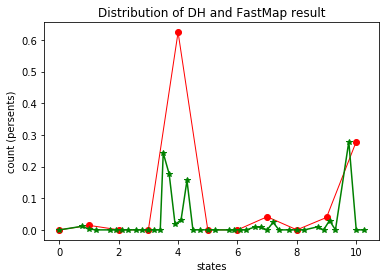

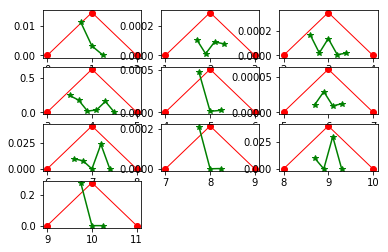

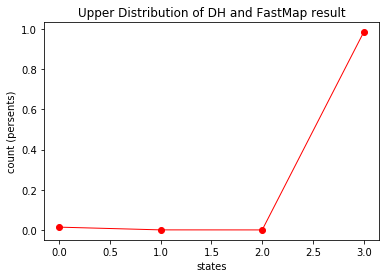

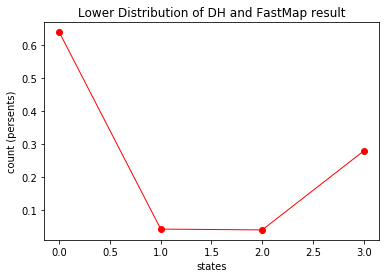

0.09076109285306941
#########Test for differential heuristic:upper
Pool size: 8
2.438122240613316
#########Test for differential heuristic:lower
Pool size: 8
0.09743690237193713
#########Test for differential heuristic:median
Pool size: 8
1.193652365307689


In [104]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 4, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 4, epsilon, dis_store, alg)
S = int(2000)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

**Summary:**

1. The result show most of the time, the `lower bound` has the better approximation of the real distance, which matches the restults of distortion. 
2. And here we can see the `upper bound` is always large than our prediction of `dismax`, which is reasonable.
3. However, why there are a large proportion of `lower bound` greater than the `dismax`?
    - **Because DH can take an advantage of great difference between edges' weight.** And maybe this situation we met the bigger edge among $d_{ij}$ and $d_{ji}$, but at the same time we still underestimate the distance because the $K$ is not that large.
4. We still need more information to see how to improve the approximation further more. Because currently, the dominate situation both shows our approximation from embedding could not help make a better choice.
    - We can try to keep adjust the strategies on every situation, and the improvements **can be improved** even more.
5. And because the orignal distortion by DH is already very good, and even better than the approximation, so we need rather improves the approximation from FastMap, or find more usable information beyond the pure distance in Euclidean space. 
    - We already showed latter that the performance of DH is unstable, and we have stable FastMap performance and the improvement is also always exists.
    - But we still need more consideration on **more usable information** based on theoretical property.

## Test the influence of edge weights 

In [50]:
filepath = "../data/roadmap/rome99.road"

def readDiGraph_type_scaled(infile, rate):
    G = nx.DiGraph()
    with open(infile) as f:
        l = f.readline()
        while l:
            if l[0] != 'a':
                l = f.readline()
                continue
            items = l.strip().split()
            if len(items) == 4:
                node1, node2, weight = items[1:]
                weight = float(weight) * rate
            elif len(items) == 3:
                node1, node2 = items[1:]
                wight = 1.0
            G.add_edge(node1, node2, weight=float(weight))
            l = f.readline()
    return G

In [51]:
rate = 0.01
G = readDiGraph_type_scaled(filepath, rate)

In [52]:
dijkstra_path_length = {}
span = G.number_of_nodes() / 20
i = 0
for node in G.nodes:
    i += 1
    if i%span == 0:
        print("\r {}% Finished".format(int(i/span)*20))
    dijkstra_path_length[node] = nx.single_source_dijkstra_path_length(G, node)

In [53]:
def thedistance_info(G):
    dis = []
    nodelist = list(G.nodes())
    for i in range(G.number_of_nodes()):
        length = dijkstra_path_length[nodelist[i]]
        dis.extend(list(length.values()))
    plt.hist(dis)
    plt.xlabel('distance')
    plt.ylabel('count (persents)')
    plt.title('Statistic of pair distances')
    plt.show()

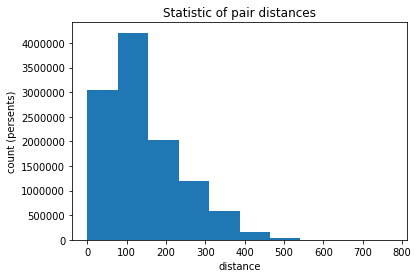

In [55]:
thedistance_info(G)

In [58]:
klist = [2,  3,  4,  5, 6, 7]
for  K  in  klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 2
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:2
Pool size: 8
(0.14565674301135167, 15877.0, 1521053.0, 462070.0)
#########Test for K:3
Pool size: 8
(0.09897669958375964, 69719.0, 1738915.0, 190366.0)
#########Test for K:4
Pool size: 8
(0.10471682488716155, 205456.0, 1660064.0, 133480.0)
#########Test for K:5
Pool size: 8
(0.10229824635176533, 262917.0, 1683327.0, 52756.0)
#########Test for K:6
Pool size: 8
(0.11752902380920544, 361145.0, 1605591.0, 32264.0)
#########Test for K:7
Pool size: 8
(0.11347132431641954, 385547.0, 1594668.0, 18785.0)


In [59]:
klist = [1, 2,  3,  4,  5]
for  K  in  klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 2
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:1
Pool size: 8
(0.69106667089358, 0.0, 445972.0, 1553028.0)
#########Test for K:2
Pool size: 8
(0.19946385570098576, 504485.0, 1182422.0, 312093.0)
#########Test for K:3
Pool size: 8
(0.3138063357976999, 1103236.0, 805219.0, 90545.0)
#########Test for K:4
Pool size: 8
(0.37530891611211303, 1388143.0, 574154.0, 36703.0)
#########Test for K:5
Pool size: 8
(0.4577582800234237, 1576538.0, 412816.0, 9646.0)


In [60]:
klist = [2,  3,  4,  5, 6, 7]
for  K  in  klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 2
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:2
Pool size: 8
(0.15490023834634986, 11807.0, 1452475.0, 534718.0)
#########Test for K:3
Pool size: 8
(0.10061653000483707, 67368.0, 1736341.0, 195291.0)
#########Test for K:4
Pool size: 8
(0.10547617856127385, 185526.0, 1668539.0, 144935.0)
#########Test for K:5
Pool size: 8
(0.0950268703104877, 229650.0, 1706660.0, 62690.0)
#########Test for K:6
Pool size: 8
(0.09643881760961279, 247648.0, 1712302.0, 39050.0)
#########Test for K:7
Pool size: 8
(0.12756307967588143, 377572.0, 1598520.0, 22908.0)


In [61]:
klist = [2, 3, 4, 5, 6]
for K1 in klist:
    for K2 in klist:
        print("#########Test for K1:{}, K2:{}".format(K1, K2))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K1, epsilon, dis_store, alg)
        embedding_max = difastmap_max(G, K2, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
        print(results)

#########Test for K1:2, K2:2
Pool size: 8
0.14822101660731962
#########Test for K1:2, K2:3
Pool size: 8
0.2533773681169644
#########Test for K1:2, K2:4
Pool size: 8
0.264817230892045
#########Test for K1:2, K2:5
Pool size: 8
0.29704628078522366
#########Test for K1:2, K2:6
Pool size: 8
0.29276208547697646
#########Test for K1:3, K2:2
Pool size: 8
0.1583804562444665
#########Test for K1:3, K2:3
Pool size: 8
0.10367747362647159
#########Test for K1:3, K2:4
Pool size: 8
0.1892612562411764
#########Test for K1:3, K2:5
Pool size: 8
0.15347348527841437
#########Test for K1:3, K2:6
Pool size: 8
0.2373504674699618
#########Test for K1:4, K2:2
Pool size: 8
0.2010729325074508
#########Test for K1:4, K2:3
Pool size: 8
0.14647129429323213
#########Test for K1:4, K2:4
Pool size: 8
0.116109154990035
#########Test for K1:4, K2:5
Pool size: 8
0.1368747707716621
#########Test for K1:4, K2:6
Pool size: 8
0.15397721875427467
#########Test for K1:5, K2:2
Pool size: 8
0.24156685034046194
#########Test for 

In [62]:
klist = [3, 4, 5, 6, 7, 8, 9, 10]
for K in klist:
    print("!!!!!!!!!The number of K: {}".format(K))
    picklist = ['upper', 'lower', 'median']
    for pick in picklist:
        print("#########Test for differential heuristic:{}".format(pick))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding = difastmap_max(G, K, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_dh_mp(G, dis_store, subset, pick)
        print(results)

!!!!!!!!!The number of K: {}
#########Test for differential heuristic:upper
Pool size: 8
2.6641057221502886
#########Test for differential heuristic:lower
Pool size: 8
0.1108186648959615
#########Test for differential heuristic:median
Pool size: 8
1.300187513440863
!!!!!!!!!The number of K: {}
#########Test for differential heuristic:upper
Pool size: 8
2.5101152348454447
#########Test for differential heuristic:lower
Pool size: 8
0.09593108027335533
#########Test for differential heuristic:median
Pool size: 8
1.1915058449558673
!!!!!!!!!The number of K: {}
#########Test for differential heuristic:upper
Pool size: 8
2.390399276489372
#########Test for differential heuristic:lower
Pool size: 8
0.08925943531968993
#########Test for differential heuristic:median
Pool size: 8
1.0606457975172126
!!!!!!!!!The number of K: {}
#########Test for differential heuristic:upper
Pool size: 8
2.073016690638368
#########Test for differential heuristic:lower
Pool size: 8
0.08851655066626639
#########Tes

Pool size: 8


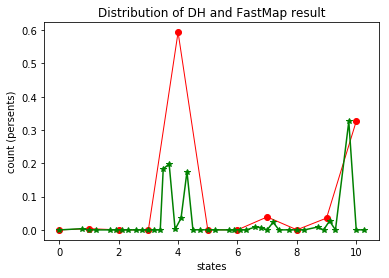

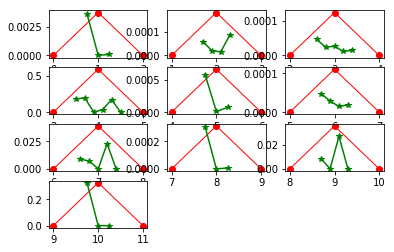

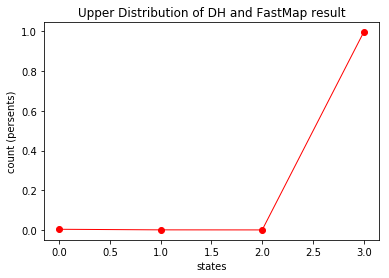

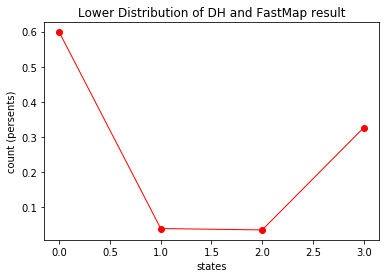

0.08002620429247838
#########Test for differential heuristic:upper
Pool size: 8
2.7008217699914328
#########Test for differential heuristic:lower
Pool size: 8
0.10785891160781666
#########Test for differential heuristic:median
Pool size: 8
1.3210416302802972


In [63]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 3, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 3, epsilon, dis_store, alg)
S = int(2000)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

In [105]:
filepath = "../data/roadmap/rome99.road"

def readDiGraph_type_even(infile):
    G = nx.DiGraph()
    with open(infile) as f:
        l = f.readline()
        while l:
            if l[0] != 'a':
                l = f.readline()
                continue
            items = l.strip().split()
            if len(items) == 4:
                node1, node2, weight = items[1:]
                weight = 1.0
            elif len(items) == 3:
                node1, node2 = items[1:]
                wight = 1.0
            G.add_edge(node1, node2, weight=float(weight))
            l = f.readline()
    return G

In [106]:
G = readDiGraph_type_even(filepath)

In [108]:
dijkstra_path_length = get_dijkstra_path_length(G)

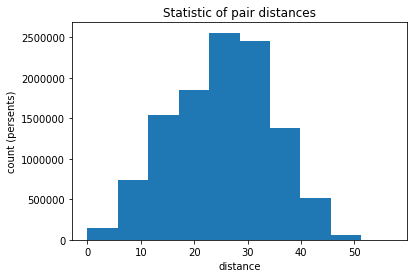

In [109]:
thedistance_info(G)

In [112]:
klist = [2,  3,  4,  5, 6, 7]
for  K  in  klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 2
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:2
Pool size: 8
(0.3537921216501952, 48558.0, 908568.0, 3040874.0)
#########Test for K:3
Pool size: 8
(0.19372684343255295, 190986.0, 1557718.0, 2249296.0)
#########Test for K:4
Pool size: 8
(0.11131180062811712, 596268.0, 2223030.0, 1178702.0)
#########Test for K:5
Pool size: 8
(0.10060533522437745, 892156.0, 2309616.0, 796228.0)
#########Test for K:6
Pool size: 8
(0.0972060225564608, 1233014.0, 2273090.0, 491896.0)
#########Test for K:7
Pool size: 8
(0.10565650953050457, 1401226.0, 2149184.0, 447590.0)


In [73]:
klist = [7, 8, 9, 10]
for  K  in  klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 2
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:7
Pool size: 8
(0.10917192458626832, 0.0, 1999000.0, 0.0)
#########Test for K:8
Pool size: 8
(0.11402014604143186, 0.0, 1999000.0, 0.0)
#########Test for K:9
Pool size: 8
(0.11661444560335459, 0.0, 1999000.0, 0.0)
#########Test for K:10
Pool size: 8
(0.13066909322401238, 0.0, 1999000.0, 0.0)


In [72]:
klist = [1, 2,  3,  4,  5]
for  K  in  klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 2
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:1
Pool size: 8
(0.6328455621767153, 0.0, 1539566.0, 459434.0)
#########Test for K:2
Pool size: 8
(0.34435314267735256, 0.0, 1911557.0, 87443.0)
#########Test for K:3
Pool size: 8
(0.27050446250373333, 61.0, 1977052.0, 21887.0)
#########Test for K:4
Pool size: 8
(0.34793298360182334, 17432.0, 1981568.0, 0.0)
#########Test for K:5
Pool size: 8
(0.4576240146529031, 112027.0, 1886973.0, 0.0)


In [113]:
klist = [2,  3,  4,  5, 6, 7, 8, 9, 10]
for  K  in  klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 2
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:2
Pool size: 8
(0.3397634205411569, 74056.0, 865950.0, 3057994.0)
#########Test for K:3
Pool size: 8
(0.1680109579334405, 252432.0, 1646070.0, 2099498.0)
#########Test for K:4
Pool size: 8
(0.13161122641804435, 590384.0, 1962934.0, 1444682.0)
#########Test for K:5
Pool size: 8
(0.09797163216738648, 820614.0, 2319146.0, 858240.0)
#########Test for K:6
Pool size: 8
(0.09885638049084883, 1142422.0, 2235584.0, 619994.0)
#########Test for K:7
Pool size: 8
(0.11312451975950018, 1496198.0, 2006322.0, 495480.0)
#########Test for K:8
Pool size: 8
(0.11451200680482124, 1902014.0, 1871834.0, 224152.0)
#########Test for K:9
Pool size: 8
(0.12012359188075213, 2028742.0, 1786994.0, 182264.0)
#########Test for K:10
Pool size: 8
(0.13617459446773547, 2423072.0, 1428068.0, 146860.0)


In [75]:
klist = [2, 3, 4, 5, 6, 7]
for K1 in klist:
    for K2 in klist:
        print("#########Test for K1:{}, K2:{}".format(K1, K2))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K1, epsilon, dis_store, alg)
        embedding_max = difastmap_max(G, K2, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
        print(results)

#########Test for K1:2, K2:2
Pool size: 8
0.42098653684904946
#########Test for K1:2, K2:3
Pool size: 8
0.601322380702411
#########Test for K1:2, K2:4
Pool size: 8
0.6758645919853101
#########Test for K1:2, K2:5
Pool size: 8
0.7287802535244805
#########Test for K1:2, K2:6
Pool size: 8
0.7160597828339327
#########Test for K1:2, K2:7
Pool size: 8
0.8864961528187632
#########Test for K1:3, K2:2
Pool size: 8
0.27577527733643137
#########Test for K1:3, K2:3
Pool size: 8
0.31095853033016807
#########Test for K1:3, K2:4
Pool size: 8
0.22471439916383318
#########Test for K1:3, K2:5
Pool size: 8
0.5125296717832989
#########Test for K1:3, K2:6
Pool size: 8
0.27773196935936784
#########Test for K1:3, K2:7
Pool size: 8
0.4464138950181875
#########Test for K1:4, K2:2
Pool size: 8
0.3028499493847213
#########Test for K1:4, K2:3
Pool size: 8
0.18866758078139687
#########Test for K1:4, K2:4
Pool size: 8
0.20572595373952515
#########Test for K1:4, K2:5
Pool size: 8
0.1880584383234236
#########Test for 

In [114]:
klist = [3, 4, 5, 6, 7, 8, 9, 10]
for K in klist:
    print("!!!!!!!!!The number of K: {}".format(K))
    picklist = ['upper', 'lower', 'median']
    for pick in picklist:
        print("#########Test for differential heuristic:{}".format(pick))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding = difastmap_max(G, K, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_dh_mp(G, dis_store, subset, pick)
        print(results)

!!!!!!!!!The number of K: 3
#########Test for differential heuristic:upper
Pool size: 8
0.6107369140594627
#########Test for differential heuristic:lower
Pool size: 8
0.2801010842300045
#########Test for differential heuristic:median
Pool size: 8
0.2945917823968205
!!!!!!!!!The number of K: 4
#########Test for differential heuristic:upper
Pool size: 8
0.5829227164157439
#########Test for differential heuristic:lower
Pool size: 8
0.2362909139342199
#########Test for differential heuristic:median
Pool size: 8
0.22982649777216052
!!!!!!!!!The number of K: 5
#########Test for differential heuristic:upper
Pool size: 8
0.5188444252035928
#########Test for differential heuristic:lower
Pool size: 8
0.208041907553956
#########Test for differential heuristic:median
Pool size: 8
0.18153763342398604
!!!!!!!!!The number of K: 6
#########Test for differential heuristic:upper
Pool size: 8
0.4967863726746566
#########Test for differential heuristic:lower
Pool size: 8
0.1840280171229863
#########Test f

Pool size: 8


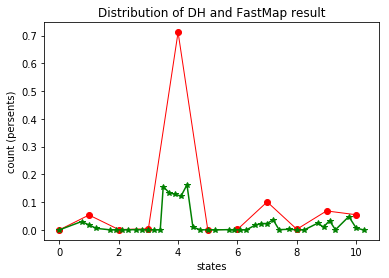

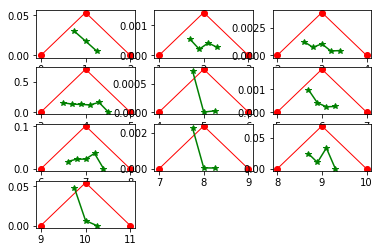

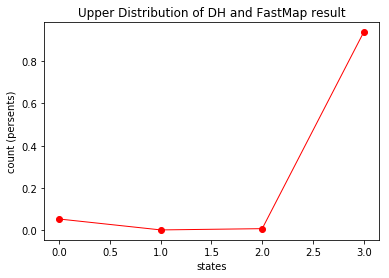

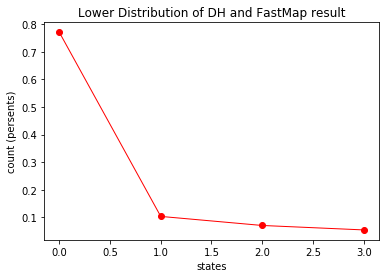

0.11223329547142662
#########Test for differential heuristic:upper
Pool size: 8
0.43915401738362864
#########Test for differential heuristic:lower
Pool size: 8
0.19338731553426086
#########Test for differential heuristic:median
Pool size: 8
0.1794725519572253


In [115]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 5, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 4, epsilon, dis_store, alg)
S = int(2000)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

**Conclution**

Here we have found some interesting phenomena which can explain the first results got on the origin roadmap which has great differential between distances.

1. The scale of edges' weight don't influence the approximation for both `DH` and `FastMap`.
2. However, the difference between pathes have a great influence on `DH`, while have nearly nothing to do with `FastMap`.
    - When edge difference is large: original roadmap with road length
        - `Lower bound` can approximate the distance very well even when the number of pivot nodes is very small.
        - `Median` and `Upper bound` are very bed.
    - When edge difference is small: equal weigth roadmap
        - `Lower bound` is much worse.
        - `Median` is the best
        - The total performance of DH is worse than FastMap.
    - FastMap
        - Doesn't influenced by the difference of distances
        - Think about `RandomGraph`, it's clear that the structure may influence the performance of FastMap a lot.
        - The combination can alway (unless $K$ is too big, which makes it's not competetive on random graph) improve the total performance and better than DH, especially when $K$ is small and the difference between disances is small.
3. But from the experiment results from Random Graph, the structure still plays a more important role.

## More interesting questions

1. Analysis the influence of `structures`.
    - We already done Random graph (general) and roadmap (grid)
    - But we need more analyses on specific structure
        - Core-periphery
        - Cycle
        - Density
        - ...
2. Improve the combination more.
    - I'm currently thinking the result of it is influenced by structure.
    - But showed by the experiment result of distribution, we can still expect a improvements.
3. More than combined strategy:
    - Currently, the core contribution seems to lies on improving DH result by fine-tune it through FastMap.
    - However, we ruined the properties of `admissible`
    - So we need to find the structure that will carry more significant improvements.
    - Or we need to find a perspective like using FastMap to turn general graph problems into Euclidean space and making use of more structures in Euclidean space. In other words, how to combine the two embedding.